<h1>More Advanced Level Task</h1>
<h2>Task 10: ML Facial recognition to detect mood and suggest songs accordingly</h2>

<b>Name: Sumant Pujari</b>

In [1]:
# import required libraries
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Check for tensorflow version and GPU allotted
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.9.1
Num GPUs Available:  0


# Initialize Training and Testing Set

In [3]:
# Initialize the train and test directory having grayscale images of faces with different emotions (48x48 pixels)
train_dir = r'C:\Users\Sumant\Desktop\FacialRecognition\train'
test_dir = r'C:\Users\Sumant\Desktop\FacialRecognition\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4985  4830      3181
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


# Visualize Dataset

Total Number of Labels: 7


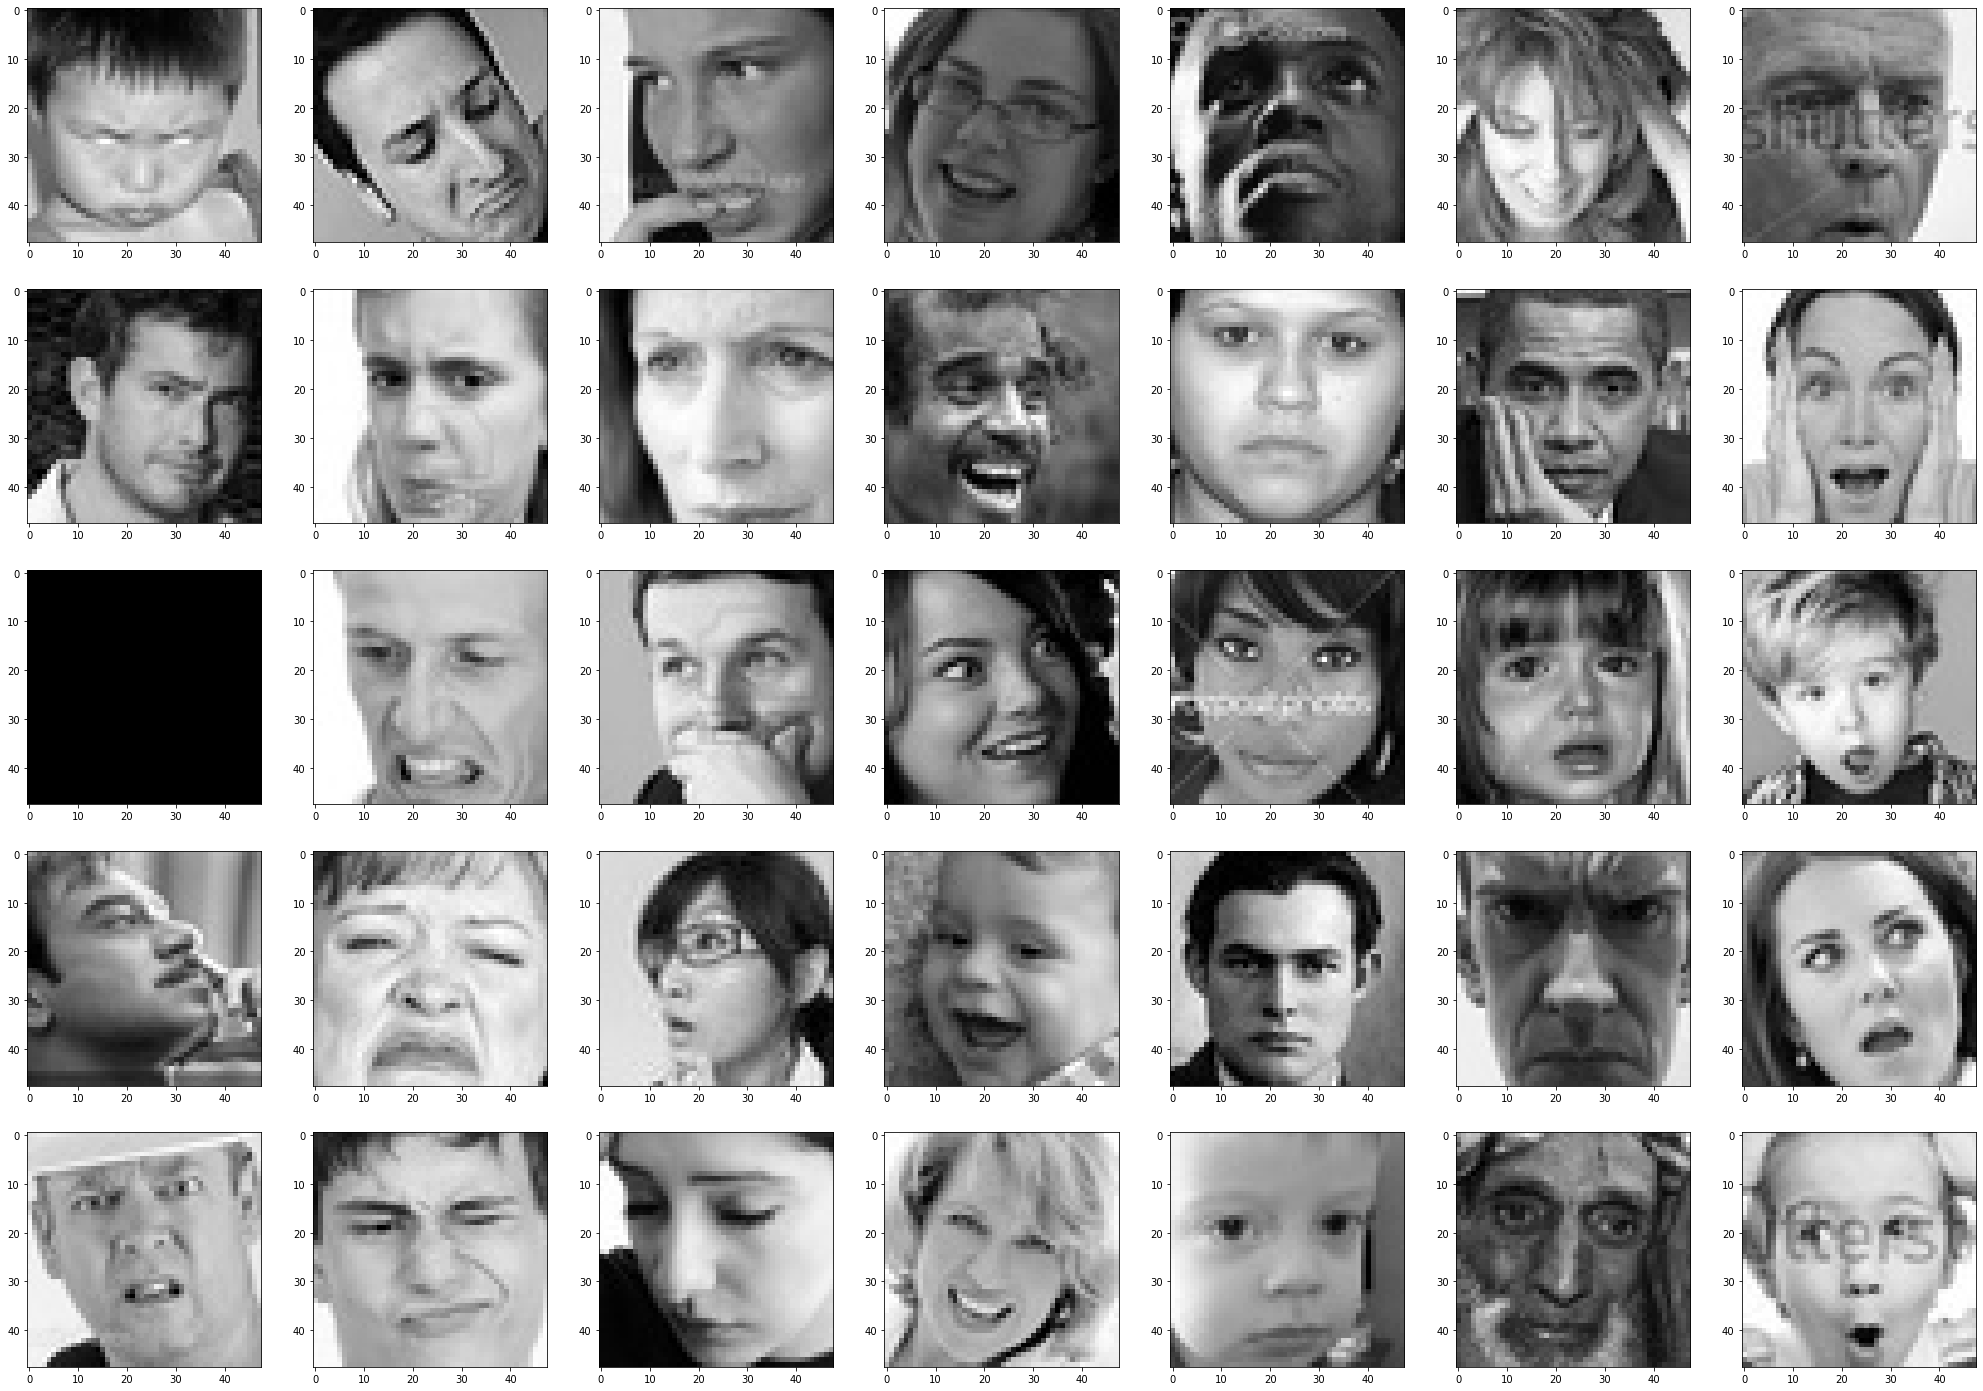

In [4]:
from skimage.io import imread

# load the train and test dataset
train_dir = r'C:\\Users\\Sumant\\Desktop\\FacialRecognition\\train\\'
test_dir = r'C:\\Users\\Sumant\\Desktop\\FacialRecognition\\test\\'
total_labels = len(os.listdir(train_dir))

print('Total Number of Labels:',total_labels)

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'\\'+os.listdir(train_dir+v)[x]), cmap='gray')

# print few sample images from train directory
plt.show()

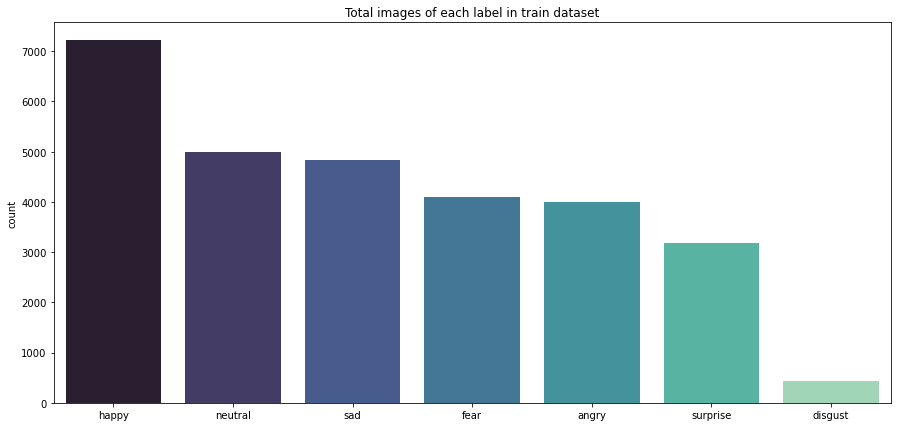

In [5]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

C:\Users\Sumant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


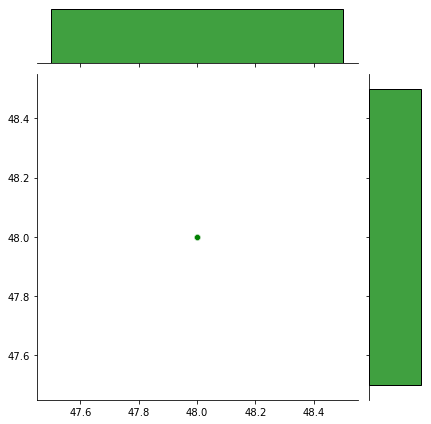

In [6]:
# retreive images from category happy from train directory
happy = os.listdir(train_dir+'happy/')
#initialize image dimensions
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

# Preprocessing of Data

In [7]:
# generating optimum training and testing set
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)


img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)


train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28739 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Building Model for Facial Recognition

In [8]:
# create a sequential model 
model = Sequential()

# start adding layer to the model
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

# overall model description
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

# Train the Model

In [9]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

# train model for appropriate epochs 
history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
449/449 [==============================] - 439s 976ms/step - loss: 1.8761 - accuracy: 0.2326 - val_loss: 2.2526 - val_accuracy: 0.2528
Epoch 2/20
449/449 [==============================] - 451s 1s/step - loss: 1.8023 - accuracy: 0.2457 - val_loss: 1.7974 - val_accuracy: 0.2667
Epoch 3/20
449/449 [==============================] - 447s 996ms/step - loss: 1.7898 - accuracy: 0.2552 - val_loss: 1.7444 - val_accuracy: 0.2930
Epoch 4/20
449/449 [==============================] - 439s 977ms/step - loss: 1.7733 - accuracy: 0.2673 - val_loss: 1.7272 - val_accuracy: 0.3001
Epoch 5/20
449/449 [==============================] - 445s 992ms/step - loss: 1.7537 - accuracy: 0.2806 - val_loss: 1.6531 - val_accuracy: 0.3421
Epoch 6/20
449/449 [==============================] - 365s 813ms/step - loss: 1.7346 - accuracy: 0.2916 - val_loss: 1.7512 - val_accuracy: 0.3225
Epoch 7/20
449/449 [==============================] - 348s 775ms/step - loss: 1.7014 - accuracy: 0.3112 - val_loss: 1.6197 - va

In [10]:
# Check for loss and accuracy of the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :",test_acc)
print("validation loss :", test_loss)

113/113 [==============================] - 13s 116ms/step - loss: 1.2200 - accuracy: 0.5247
validation accuracy : 0.5246586799621582
validation loss : 1.2200355529785156


In [11]:
# Save the Model
model.save("FacialRecognModel.h5")

# Visualize Model Evaluation

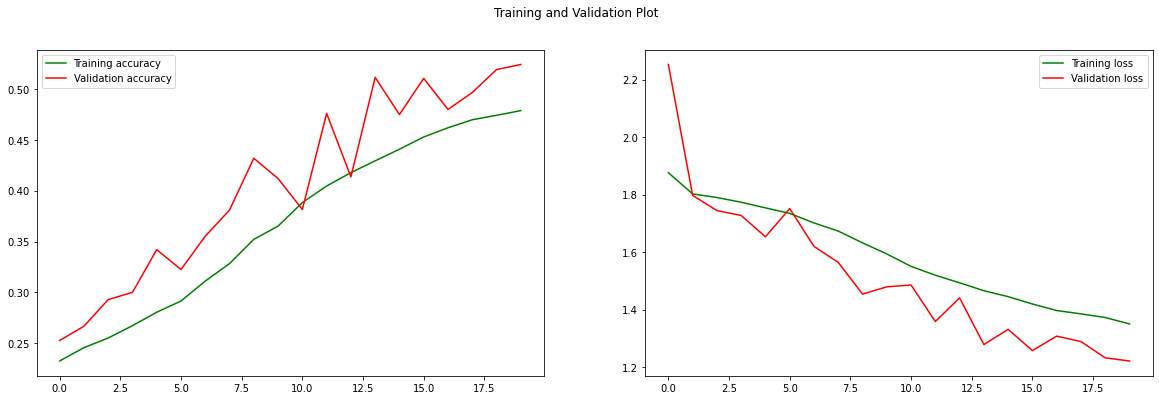

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and Validation Plot')
plt.show()

113/113 [==============================] - 13s 115ms/step
              precision    recall  f1-score   support

       angry       0.46      0.33      0.39       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.05      0.08      1024
       happy       0.67      0.86      0.76      1774
     neutral       0.39      0.72      0.51      1233
         sad       0.45      0.28      0.35      1247
    surprise       0.60      0.77      0.67       831

    accuracy                           0.52      7178
   macro avg       0.42      0.43      0.39      7178
weighted avg       0.49      0.52      0.48      7178





C:\Users\Sumant\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sumant\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sumant\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


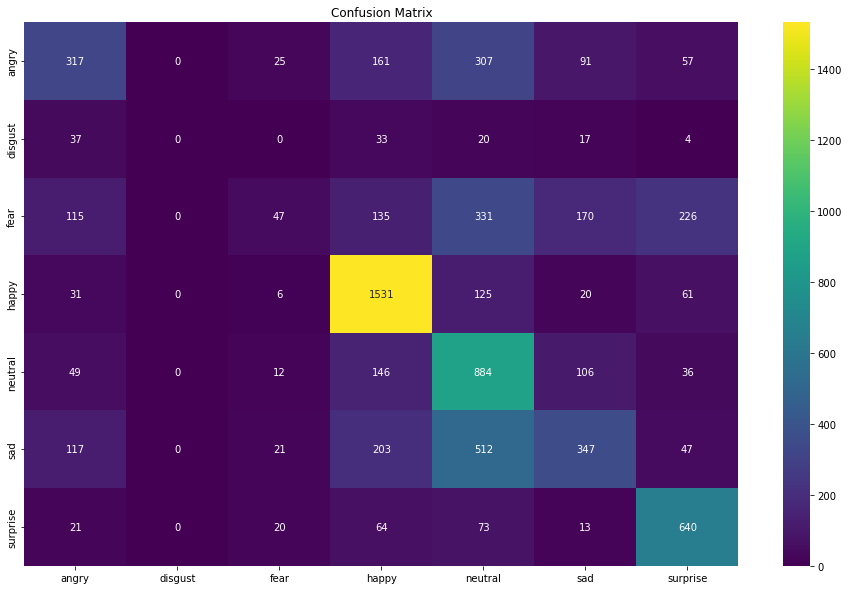

In [13]:
# Classification report for the model
y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

# Confusion matrix
confusion_mat = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(confusion_mat, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.show()

# Test the Model

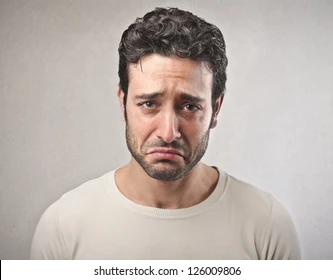

In [32]:
# Testing our model with new image
image = cv2.imread('C:\\Users\\Sumant\\Desktop\\FacialRecognition\\images\\sad.jpg')
from IPython.display import Image
Image(filename='C:\\Users\\Sumant\\Desktop\\FacialRecognition\\images\\sad.jpg')

In [52]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model
model = tf.keras.models.load_model("FacialRecognModel.h5",custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The Model considers this Emotion to be:",label)

1/1 [==============================] - 0s 90ms/step
  Angry   prediction rate is   0.09%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.07%
   Sad    prediction rate is   0.53%
 Surprise prediction rate is   0.16%
 Neutral  prediction rate is   0.06%


 The Model considers this Emotion to be: Sad


In [55]:
# check the predicted category for particular action
if (label=='Angry'):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Angry"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing","label","song: ",d)
    os.system(song)

elif (label=='Disgust'):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Disgust"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing:",d)
    os.system(song)
    
elif (label=="Happy"):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Happy"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing:",d)
    os.system(song)
    
elif (label=='Sad'):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing",label,"song: ",d)
    os.system(song)
    
elif (label=='Surprise'):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Surprise"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing:",d)
    os.system(song)

elif (label=='Neutral'):
    path="C:\\Users\\Sumant\\Desktop\\FacialRecognition\\Songs\\Neutral"
    files=os.listdir(path)
    d=random.choice(files)
    song=path+d
    print("Now Playing:",d)
    os.system(song)

Now Playing Sad song:  Sad1.mp3


<b>Conclusion :</b><br>
1. Using Deep Learning, Model has been successfully created to Recognize Facial Expressions and play a particular music.
2. Due to lack of images in dataset model accuracy varies.
3. Model accuracy can be affected due to the number of batch size, epochs and learning rate.